In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import show


# utils

import datetime
import time
import collections
import ipywidgets as widgets
from pathlib import Path
from IPython.display import display, clear_output

import plotly

# our code (mark it at autoreload at every cell execution - useful in developement mode)
import sys
sys.path.append('..')
%load_ext autoreload
%autoreload 1
%aimport runners_utils
%aimport study_utils

We import the notebook located to : '../../Scraping/Weather', the notebook is used to get weather informations on the races studied.

the following method used can be found one: http://nbviewer.jupyter.org/github/jupyter/notebook/blob/master/docs/source/examples/Notebook/Importing%20Notebooks.ipynb

In [2]:
notebook_loader = runners_utils.NotebookLoader(['../../Scraping/Weather'])
notebook_loader.load_module('compute_information_station')
import compute_information_station

compute_information_station
compute_information_station
../../Scraping/Weather/compute_information_station.ipynb
importing Jupyter notebook from ../../Scraping/Weather/compute_information_station.ipynb
locale for Mac


In [3]:
PATH_TO_DATA = '../../Scraping/DataSport/Data/Runners/'
# change the name to the global like website but need to see if the website still works.
RUNNERS_FILE = 'runners_2009.csv'
RUNS_FILE = 'runs_2009.csv'

Methode related to compute_information_station method.

In [4]:
def compute_weather_information_race(eventName, lattitue, longitude, runs_df):
    '''
    Returns weather informations about the race from 1999 to 2016,
    defined by an eventName, a lattitue and a longitude
    
    Parameters
        - eventName: name event
        - lattitue: lattitude event
        - longitude: longitude event
        - runs_df: dataframe contains the different runs
    
    Return
        - Dataframe contains the mean of weather informations from 6am to 8pm
    '''
    
    information_race = []
    information_date = []
    
    # getting weather for specific place.
    for date in runs_df['eventDate'][runs_df['eventName'] == eventName].unique():
        print(date)
        page  = compute_information_station.retrieve_weather_of_location_by_date(lattitue, longitude, date)

        # if we can reach the web page
        print(page.status_code)
        if page.status_code == 200:
            try:
                df = compute_information_station.format_complete_reading(page)
                clean_df = compute_information_station.clean_reading_dataframe(df)
                clean_df[clean_df['Hour'].isin(range(6,20))]
                serie_mean = clean_df.mean(axis=0)
                clean_df = pd.DataFrame(dict(zip( serie_mean.index,  serie_mean.values)), index= [0])
                information_race.append(clean_df)
                information_date.append(date)

            except AttributeError:
                print('error during handling ' + str(date))
                # We sleep some time to avoid to be blacklisted
                time.sleep(5)
                continue
            except ValueError:
                print('error during handling ' + str(date))
                time.sleep(5)
                continue

        # We sleep some time to avoid to be blacklisted
        time.sleep(10)

    if len(information_race) != 0:
        weather_information = pd.concat(information_race)
        weather_information['eventDate'] = information_date
        weather_information['eventName'] = eventName
    
    else:
         weather_information = []   
    
    return weather_information

def compute_weather_information(dict_eventName, runs_df):
    '''
    Returns weather informations about the race from 1999 to 2016,
    defined in dict_eventName. 
    
    Parameters
        - dict_eventName: containing multiple race and location
          example:  event = {
                                'Lausanne Marathon': [46.226793,6.140639],
                                '20km de Lausanne' : [46.226793,6.140639],
                            }
        - runs_df: dataframe contains the different runs
    
    Return
        - Dataframe contains the mean of weather informations from 6am to 8pm for all race in  dict_eventName
    '''
    
    path_data = './Data/'
    indication = 'weather_'
    information_races = []
    
    # loop to 
    for key, value in dict_eventName.items():
        print('Computing informations for : ' + key)
        info_file = Path(path_data + indication + key + '.csv')
        
        # if the file doesn't already exist, we compute the new values.
        if not info_file.is_file():
            information_race = compute_weather_information_race(key, value[0], value[1], runs_df)
            
            if len(information_race) != 0: 
                information_race.to_csv('Data/' + indication + key + '.csv')
                information_races.append(information_race)
        
        # else we ge the data.
        else:
            information_races.append(pd.read_csv('Data/'  + indication + key + '.csv'))
    
    return pd.concat(information_races)

## Prepocessing data

In [5]:
runners = pd.read_csv(PATH_TO_DATA + RUNNERS_FILE)
runs = pd.read_csv(PATH_TO_DATA + RUNS_FILE)

In [6]:
runners.head()

,acode,birthyear,location,name
0,LHB8QSM5,1970,F-Niort,Besse Daniel
1,A8L97QG7,1950,CH-Lausanne,Le Chi Thanh
2,M1STF1KE,1963,CH-Yverdon-les-Bains,Puglia Alfio
3,XX6AYSY3,1948,CH-St-Légier,Hofer Thierry
4,5U39UU55,1956,CH-Lausanne,Mebold Jacques


In [7]:
runners['birthyear'].describe()

count      61.000000
mean     1958.868852
std        11.381967
min      1934.000000
25%      1950.000000
50%      1959.000000
75%      1965.000000
max      1988.000000
Name: birthyear, dtype: float64

As we can notice our subset of runners is quite old, the result of the study should be taken carefully.

In [8]:
runners.head()

,acode,birthyear,location,name
0,LHB8QSM5,1970,F-Niort,Besse Daniel
1,A8L97QG7,1950,CH-Lausanne,Le Chi Thanh
2,M1STF1KE,1963,CH-Yverdon-les-Bains,Puglia Alfio
3,XX6AYSY3,1948,CH-St-Légier,Hofer Thierry
4,5U39UU55,1956,CH-Lausanne,Mebold Jacques


In [9]:
runs.head(5)

,acode,catRank,categoryName,entryArt,entryPayart,eventDate,eventName,eventRaceNr,overCategoryName,overRank,provider,raceNr,racePayload,resultState,runtime,startNumber
0,LHB8QSM5,174.0,Semi Dames III,payé,poste/banque,31.10.2010,Lausanne Marathon,D32CE53389FBC48DA5A299AD88EF507F,Semi Marathon Dames,549.0,Datasport,12110,A9946627764916E7A546287C02CAF250B9C37B40A76428...,classé,"2:00.32,9",4510
1,A8L97QG7,41.0,20km H60 Hommes,payé,BVR,24.04.2010,20km de Lausanne,65B4F931D947828EBDA1D5E2A70F91B4,20km Overall Hommes,1940.0,Datasport,12102,3ADFE6008C38E514066198A8D350D39DD21D6E649A80E6...,classé,"1:54.36,8",2501
2,A8L97QG7,115.0,Marathon Hommes IV,payé,BVR,25.10.2009,Lausanne Marathon,A6281A6FD50821D6A90BF39F7D9CDADD,Marathon Hommes,791.0,Datasport,11110,721103B8B78B8D536850377EA409944B57E55B0247B14B...,classé,"4:07.55,8",1362
3,A8L97QG7,71.0,Marathon Hommes 4,payé,en ligne,10.05.2009,Genève Marathon for UNICEF,D8C73121FC8EEF4562909F6C5CBE1259,Overall Marathon Hommes,492.0,Datasport,11934,3E4F1A05C8F23F34A814EE78B795235863EA6340B58B9F...,classé,"4:04.47,6",821
4,A8L97QG7,69.0,20km H55 Hommes,payé,BVR,25.04.2009,20km de Lausanne,25C279441B2CE5123EB70E23E86D80C8,20km Overall Hommes,1823.0,Datasport,11102,B5E7077A0A79F19B6877C26AF586F5987E13E32046AA71...,classé,"1:54.54,6",1670


In [10]:
runs_before_preprocessing = runs.copy()

runs : contains all informations aboute races.<br/>
runners : contains all informations about studied runners.
runs_before_preprocessing : contains a copy of runs dataframe before the preprocessing.

The columns 'acode' make the link between the two Dataframes.

We remove all abandon row and all useless columns

In [11]:
runners_utils.preprocess_runners(runners)

In [12]:
runs = runners_utils.remove_outliers(runs)

For each races we compute the distance from the category name, overCategoryName and eventName.
We remove all other sports than running to remain coherent during the overall study (note: a lot of runners have made some triathlons, we have to take it into account.)

In [13]:
runs['distance (km)'] = runs.apply(runners_utils.compute_distance_from_category,axis=1)
runs = runs[~runs['distance (km)'].isnull()]

For each runners, we compute the gender (male/female).

In [14]:
result = runs.apply(runners_utils.compute_sex, args=(runners,), axis=1)

In order to have enought results for each runners we take runners who have 10 races from 1999-2016.

In [15]:
runs = runners_utils.select_runners_by_numbers_of_runs(runs, 10)

From the Dataframe, we compute new features : 'age', 'time (s)', 'speed (m/s)', 'eventDate'

In [16]:
runs['age'] = runs.apply(runners_utils.compute_age, args=(runners,), axis=1)

In [17]:
runs['time (s)'] = runs.apply(runners_utils.transform_string_to_second, axis=1)
runs['speed (m/s)'] = runs['distance (km)']*1000 / runs['time (s)']

In [18]:
runs['eventDate'] = runs.apply(runners_utils.compute_date_event, axis=1)

In [19]:
runners_utils.remove_useless_columns(runs)

After all operations of preprocessing, we obtain 47 runners who have finished more than 10 races.

In [20]:
print ('study rely on : ' + str(len(runs['acode'].unique())) + ' runners')
print ('Total races : ' + str(len(runs.index)) + ' races')

study rely on : 47 runners
Total races : 3535 races


In [21]:
runs.head()

,acode,catRank,categoryName,eventDate,eventName,overCategoryName,overRank,runtime,distance (km),age,time (s),speed (m/s)
1,A8L97QG7,41.0,20km H60 Hommes,2010-04-24,20km de Lausanne,20km Overall Hommes,1940.0,"1:54.36,8",20.0,60,6876.0,2.908668
2,A8L97QG7,115.0,Marathon Hommes IV,2009-10-25,Lausanne Marathon,Marathon Hommes,791.0,"4:07.55,8",42.0,59,14875.0,2.823529
3,A8L97QG7,71.0,Marathon Hommes 4,2009-05-10,Genève Marathon for UNICEF,Overall Marathon Hommes,492.0,"4:04.47,6",42.0,59,14687.0,2.859672
4,A8L97QG7,69.0,20km H55 Hommes,2009-04-25,20km de Lausanne,20km Overall Hommes,1823.0,"1:54.54,6",20.0,59,6894.0,2.901073
5,A8L97QG7,107.0,Marathon Hommes IV,2008-10-26,Lausanne Marathon,Marathon Hommes,670.0,"4:02.02,8",42.0,58,14522.0,2.892164


## Statistical study.

### Performance study

In [22]:
races_59 = runs[runs['acode'] == 'FU3KDU5G']
races_38 = runs[runs['acode'] == 'G756ZTL6']
races_26 = runs[runs['acode'] == 'FFJBKFSN']

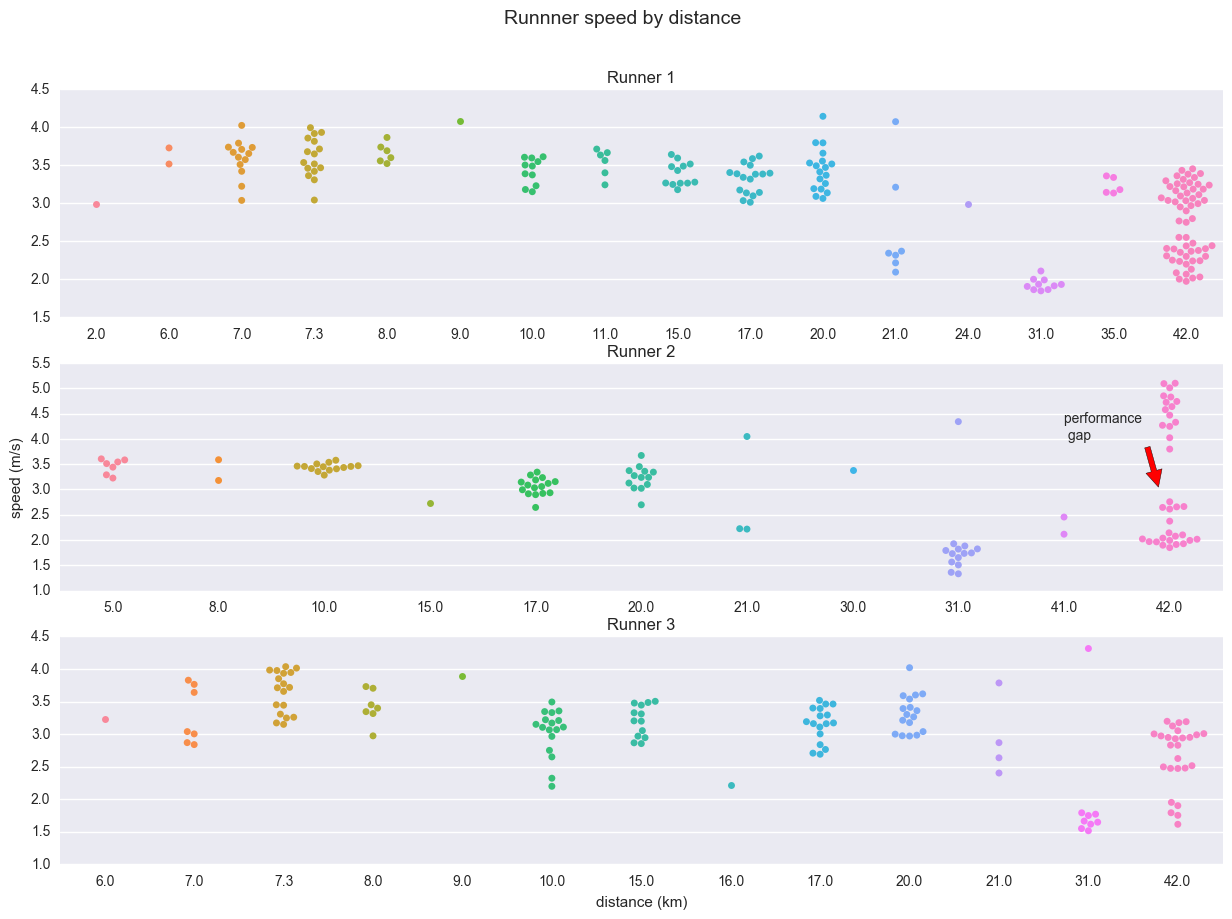

In [23]:
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(15, 10)
fig.suptitle('Runnner speed by distance', fontsize=14)
annotation_plot2 = ['performance \n gap',(9.9,3), (9,4)]
runners_utils.presentation_performance_runners(fig, [races_59, races_38, races_26], annotation_plot2)

As we can notice from the graph above we see some enormous disparity between speed of race who have the same distance.
Futhermore an other interesting fact is the speed seems lower for the race of 31Km (http://www.sierre-zinal.com) than marathons.
The current study try to focus on vizualisation of multiple factors that could explain these gap:
 - Age
 - Training (As we don't have any personnal information, we take as reference how much they race)
 - Experience
 - Weather / altitude

### Training Part

In [24]:
runners_informations = runners_utils.compute_dataframe_groupby(runs, runs_before_preprocessing) 

We split the set of runners into two groups, one have race more than 175 and the other less. The first group represent the runners who raced a lot. Indeed 175 events between 1999-2016 which make 10 races/years.

The value 175 is totally subjective, but we found interesting to differentiate two groups of runners to study if different external factor affects less runners who get used of it.

In [25]:
experienced_runners =  runners_informations[runners_informations['overall number race'] > 175].index.values
inexperienced_runners =  runners_informations[runners_informations['overall number race'] <= 175].index.values

In [26]:
runners[runners['acode'].isin(experienced_runners)]['birthyear'].describe()

count      11.000000
mean     1949.818182
std         9.053377
min      1934.000000
25%      1945.500000
50%      1948.000000
75%      1954.500000
max      1966.000000
Name: birthyear, dtype: float64

In ou subset the frequent runners are very old.

In [27]:
runners_informations.describe()

,number_race,overall number race,number abandon
count,47.000000,47.000000,47.000000
mean,75.212766,131.191489,10.872340
std,44.024665,98.605194,12.002929
min,14.000000,21.000000,0.000000
25%,41.500000,64.000000,2.000000
50%,72.000000,109.000000,7.000000
75%,93.000000,170.000000,16.000000
max,206.000000,514.000000,64.000000


The study carry on 47 runners, as we can notice they are not begginers some of them have more the 500 events on 17 years which mean more than 2 events each month during a period of 17 years... This is huge knowing that for a debutant the recommended waiting time before getting  is 3-4 to completely get health after http://www.runnersworld.com/ask-coach-jenny/how-many-marathons-can-you-run-in-a-year.

We should keep in mind that everyone is different, the study is clearly individual, everybody reacts differently, we should push the study further to confirm any hypothesis.

In [28]:
runs_before_preprocessing['eventDate'] = runs_before_preprocessing.apply(runners_utils.compute_date_event, axis=1)
runs_before_preprocessing['year'] = runs_before_preprocessing['eventDate'].apply(lambda x: int(x.year))

The result above has been done on a total of 47 runners, As we can expect generally the number of abandon grows with proportionnaly with the number of race done.
An interesting fact is the 

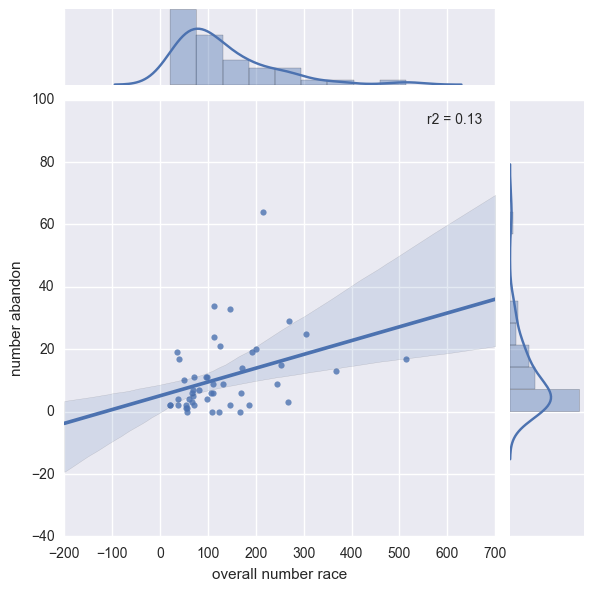

In [29]:
runners_informations["overall number race"] = runners_informations["overall number race"].apply(lambda x: np.int(x))
runners_informations["number abandon"] = runners_informations["number abandon"].apply(lambda x:  np.int(x))

sns.jointplot(runners_informations["overall number race"], runners_informations["number abandon"], kind="reg", stat_func=runners_utils.r2)

The R-squared value is to small to confirm anything about such linear relation between abandon the number of race runned and the number of abandon.

Two explanations are possible, one is that we are missing data on training of each runners, some of them could only race instead of others who train a lot, futhermore we don't have any data about daily life and lifestyle, this could explain one aspect of the overtraining http://www.mensfitness.com/training/pro-tips/12-signs-youre-overtraining

Let's study the now the effect of the trainings on the overall performance, in order to isolate as much as possible independant variable (altitude, period of the year, ascending elevation) the following study focused on the marathon of lausanne.

In [30]:
print('number of races : ' + str(len(runs[(runs['eventName'] == 'Lausanne Marathon') & (runs['distance (km)'] == 42)].index)))
print('number of runners : ' + str(len(runs[(runs['eventName'] == 'Lausanne Marathon') & (runs['distance (km)'] == 42)]['acode'].unique())))

number of races : 190
number of runners : 27


The marathon of Lausanne seems to be a good one with 27 runners out of 47

In [31]:
runs_event_cleaned = runners_utils.compute_dataframe_marathon_performance(runs, runs_before_preprocessing)

In [32]:
marathon_lausanne = runs_event_cleaned[(runs_event_cleaned['eventName'] == 'Lausanne Marathon') & (runs_event_cleaned['distance (km)'] == 42)]
marathon_lausanne = marathon_lausanne[marathon_lausanne['acode'].isin(runners['acode'][runners['gender'] == 'male'])]
marathon_lausanne = marathon_lausanne[marathon_lausanne['speed (m/s)'] < 6]
marathon_lausanne = pd.merge(runners[['acode','number_acode']],marathon_lausanne,on='acode')

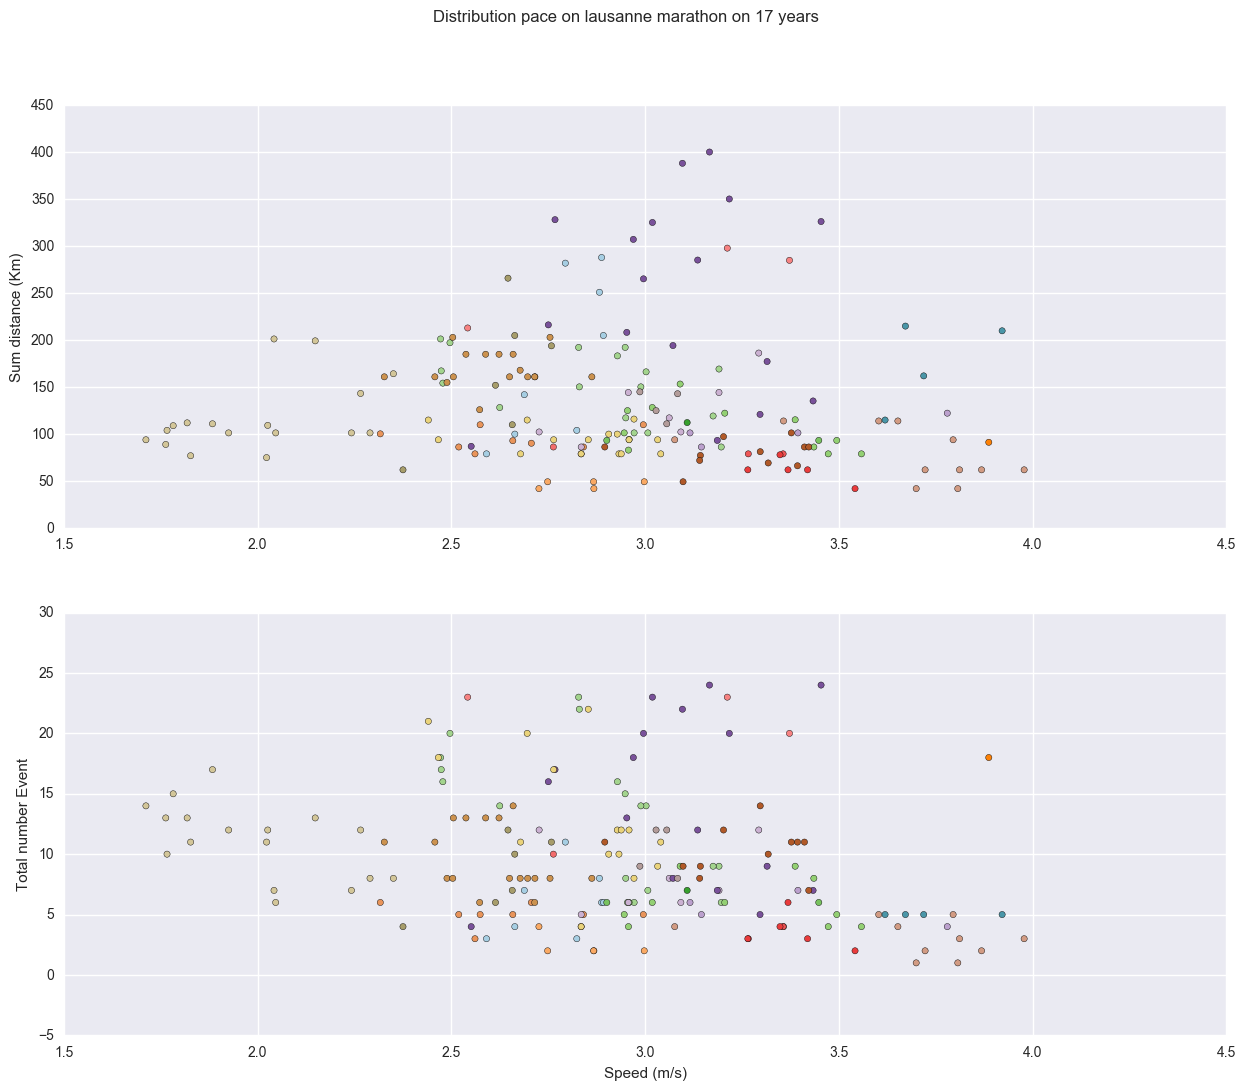

In [33]:
fig = plt.figure()
fig.tight_layout
fig.set_size_inches(15, 12)
fig.suptitle('Distribution pace on lausanne marathon on 17 years', fontsize=12)
runners_utils.diplay_comparaison_runners_performance(fig, marathon_lausanne)

- Sum distance (km) represents the kilometers/years in competition for each runners.
- Total number event represents the number event/years in competition for each runners.
            
From an individual point of view, generally the sum distance (Km) and total event remain constants through years for a specific runner (each color represents a runner). 

From a collective point of view, there is no specific pattern form the graph above. The first two best results have been obtained by different runners with a huge difference of kilometers/years.

We need to individualize the study if we want to find a relation between external factors and the performance. By individualizing the study, we can isolate some missing information like age, genetic, training, etc.

### Coefficient study

In order to individualize the study, we compute some 'coefficients' for each interesting features.

To individualize the study, we compute some 'coefficients' for each interesting feature. A coefficient is defined by the difference between the value (temperature, Humidity, ect) for the current row and the value obtained for the best time of the race for the same specific race. (current_value - bestTime_value). 
The idea behind the ‘coefficient’ is to try to isolate as much external factors as possible. We also suppose that the route of the different races does not change a lot between the multiple races editions as we don't have this information. 

For instance, if the temperature coefficient is positive, it means that the temperature was higher for this specific race compared to the temperature of the best time race for the same runners..

The coefficient is bring back to [-1,1] for displaying the information easily 

#### Coefficient performance

We compute Performance coefficient.

In [34]:
runs_event_cleaned['Performance coefficient'] = runs_event_cleaned.apply(runners_utils.compute_coefficient, args=(runs_event_cleaned, 'sum distance (km)',), axis=1)

In [35]:
runs_event_cleaned['Event coefficient'] = runs_event_cleaned.apply(runners_utils.compute_coefficient, args=(runs_event_cleaned, 'overall number events',), axis=1)

In [36]:
runs_event_cleaned['Age coefficient'] = runs_event_cleaned.apply(runners_utils.compute_coefficient, args=(runs_event_cleaned, 'age',), axis=1)

We define the handler for the widget.

In [37]:
possible_value_coefficient_performance = ['Performance coefficient', 'Event coefficient', 'Age coefficient']
initial_value_performance = 'Performance coefficient'
# ----------------------------------------------------------------------------------------
# HANDLERS
def update_performance_comparison(change):
    if change['new'] not in possible_value_coefficient_performance:
        return
    clear_output()
    global selected_performance_comparison
    selected_performance_comparison = change['new']
    fig = runners_utils.plot_coefficient_distribution(runs_event_cleaned, inexperienced_runners, experienced_runners, selected_performance_comparison, bin_size=0.07)
# HANDLERS (END)
# ----------------------------------------------------------------------------------------

# Widget for performance criteria
performance_comparison_widget = widgets.Dropdown(options=possible_value_coefficient_performance, value=initial_value_performance)
performance_comparison_widget.observe(update_performance_comparison)

In [38]:
display(performance_comparison_widget)
fig = runners_utils.plot_coefficient_distribution(runs_event_cleaned, inexperienced_runners, experienced_runners, initial_value_performance)

The Shapiro-Wilk test the normality of the distribution, https://plot.ly/python/normality-test/ . In an ideal world if the coefficient have no impact on the performance the coefficient should follow a normal law, which mean the parameter studied improve the performance as much as degrade it.

In [39]:
distribution_age_runners = runners_utils.display_age_distribution(runs_event_cleaned['age'], 'Age distribution')

The group of runners had a mean age of 52,67, which is very high but we have to keep in mind that we have data of runners from 1999.
It is the distribution of age on multiple events, one runners appear muultiple times

In [40]:
runs_event_cleaned['diff best time (s)'] = runs_event_cleaned.apply(runners_utils.compute_best_time, args=(runs_event_cleaned,), axis=1)

In [41]:
runners_utils.display_scatter_matrix(runs_event_cleaned[['Performance coefficient','Event coefficient','Age coefficient','diff best time (s)']])

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



We see a that event and performance coeeficient foolow a pattern, this is quite normal because they are dependant.

### Weather information

We get weather data for the following races, these are the races with the most runners in our study.

In [42]:
study_race = {
              'Lausanne Marathon': [46.226793,6.140639],
              '20km de Lausanne' : [46.226793,6.140639],
              'Morat-Fribourg' : [46.915183, 7.107277],
              'Course de l\'Escalade, Genève' : [46.203884, 6.145191],
              'Sierre-Zinal, Sierre' : [46.289716, 7.549294],
              'Zermatt Marathon, Zermatt' : [45.976906, 7.658001]
             }

Marathon_information = compute_weather_information(study_race, runs)

Computing informations for : 20km de Lausanne
Computing informations for : Sierre-Zinal, Sierre
Computing informations for : Lausanne Marathon
Computing informations for : Morat-Fribourg
Computing informations for : Zermatt Marathon, Zermatt
Computing informations for : Course de l'Escalade, Genève


In [43]:
runs_event_cleaned['eventDate'] = runs_event_cleaned['eventDate'].apply(lambda x : str(x))
Marathon_information['eventDate'] = Marathon_information['eventDate'].apply(lambda x : str(x))
Marathon_information.drop('Unnamed: 0', inplace = True, axis=1)
run_cleaned_weather_information = pd.merge(runs_event_cleaned, Marathon_information, how='inner', on=['eventName','eventDate'], left_on=None, right_on=None,)

In [44]:
run_cleaned_weather_information['Humidity coefficient'] = run_cleaned_weather_information.apply(runners_utils.compute_coefficient, args=(run_cleaned_weather_information, 'Humidity (%)',), axis=1)

In [45]:
run_cleaned_weather_information['Temperature coefficient'] = run_cleaned_weather_information.apply(runners_utils.compute_coefficient, args=(run_cleaned_weather_information, 'Temperature (°C)',), axis=1) 

In [46]:
run_cleaned_weather_information['Wind coefficient'] = run_cleaned_weather_information.apply(runners_utils.compute_coefficient, args=(run_cleaned_weather_information, 'Wind (average) (km/h)',), axis=1) 

In [47]:
possible_value_coefficient = ['Wind coefficient', 'Temperature coefficient', 'Humidity coefficient']
initial_value = 'Wind coefficient'
# ----------------------------------------------------------------------------------------
# HANDLERS
def update_weather_comparison(change):
    if change['new'] not in possible_value_coefficient:
        return
    clear_output()
    global selected_performance_comparison
    selected_performance_comparison = change['new']
    fig = runners_utils.plot_coefficient_distribution(run_cleaned_weather_information, inexperienced_runners, experienced_runners, selected_performance_comparison)
# HANDLERS (END)
# ----------------------------------------------------------------------------------------

# Widget for performance criteria
weather_comparison_widget = widgets.Dropdown(options=possible_value_coefficient, value=initial_value)
weather_comparison_widget.observe(update_weather_comparison)

In [48]:
display(weather_comparison_widget)
fig = runners_utils.plot_coefficient_distribution(run_cleaned_weather_information, inexperienced_runners, experienced_runners, initial_value)

In [49]:
run_cleaned_weather_information['diff best time (s)'] = run_cleaned_weather_information.apply(runners_utils.compute_best_time, args=(run_cleaned_weather_information,), axis=1)

In [50]:
runners_utils.display_scatter_matrix(run_cleaned_weather_information[['Wind coefficient', 'Temperature coefficient', 'Humidity coefficient','diff best time (s)']])

This is the format of your plot grid:
[ (1,1) x1,y1 ]    [ (1,2) x2,y2 ]    [ (1,3) x3,y3 ]    [ (1,4) x4,y4 ]  
[ (2,1) x5,y5 ]    [ (2,2) x6,y6 ]    [ (2,3) x7,y7 ]    [ (2,4) x8,y8 ]  
[ (3,1) x9,y9 ]    [ (3,2) x10,y10 ]  [ (3,3) x11,y11 ]  [ (3,4) x12,y12 ]
[ (4,1) x13,y13 ]  [ (4,2) x14,y14 ]  [ (4,3) x15,y15 ]  [ (4,4) x16,y16 ]



Features are not linked together

As conclusion, there are no big difference between experienced runners and inexperienced runners.

Runners got their best performance when they are younger (knowing the mean age of the group of runners is 52,47 years) and when the temperature is warmer. More strangely, runners got their best performance when they raced less kilometer than other years; Here are some explanations to the phenomena:
- One explication could be that runners raced more when they are getting older, but we applied a regression test and we get a R-squared value equals to 0,0066, which mean there is no linear link between the two variables.
- A lot of runners could have made other sport events not considered in our study like triathlon, cycle, walks, .... This hypothesis seems to be confirmed as this this effect disappears with the Event coefficient.
- It could be an effect of the over-training.

One other important aspect is the positive and negative impact of the Wind coefficient as the force and the direction of the wind could change the performance of the runners.

### Generate Json 

In [51]:
weather_coefficient =  runners_utils.generate_plotly_figure(run_cleaned_weather_information, possible_value_coefficient, inexperienced_runners, experienced_runners)

In [52]:
performance_coefficient =  runners_utils.generate_plotly_figure(runs_event_cleaned, possible_value_coefficient_performance, inexperienced_runners, experienced_runners, bin_size=0.07)

In [53]:
data_to_export = {'distribution-age': distribution_age_runners,
                  'weather-coefficient' : weather_coefficient,
                  'performance-coefficient' :performance_coefficient
                 }

In [54]:
#for name, data in data_to_export.items():
    # Note: We set indent to None in order to minify JSON
#    study_utils.convert_to_JSON(object=data, file_name=name, path='./Data', encoder=plotly.utils.PlotlyJSONEncoder, indent=None)